In [1]:
import pandas as pd
import math
import datetime as dt
import time
import json
import numpy as np
import warnings
import tqdm
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


from xgboost import XGBClassifier

import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers

keras.__version__

'2.6.0'

In [2]:
from PHQ9_preprocessing import preprocessing
df_phq9 = pd.read_csv('/home/diogo_mota/Dropbox/QMUL/MSc_Project/dataset/survey/PHQ-9.csv')

In [3]:
def phq9_cleaner(dataframe):
    
    score_dict = {'Not at all':0, 'Several days':1, 'More than half the days':2, 'Nearly every day':3}
    dataframe = dataframe.drop(['Response'], axis=1)
    #column_list = ['uid', 'type']
    
    column_list = list(dataframe.columns)
    
    full_score = []
    for i in range(len(dataframe)):
        value_list = list(dataframe.iloc[i])
        score_list = []
        
        for val in value_list:

            if type(val)==str:

                if len(val)>4:
                    score_list.append(score_dict[val])
                else:
                    score_list.append(val)
            elif math.isnan(val):
                score_list.append(np.nan)
        full_score.append(score_list)
        
    return pd.DataFrame(full_score, columns = column_list)

def phq9_score(dataframe):
    
    final_score = []
    user = []
    pre_list = []
    
    for i in range(len(dataframe)):
        
        answer = list(dataframe.iloc[i])
        answer_clean = answer[2:]
        final_score.append(np.sum(answer_clean))
        user.append(answer[0])
        pre_list.append(answer[1])
        
    df = pd.DataFrame(zip(user, pre_list, final_score), columns = ['uid', 'type', 'PHQ9 Score'])
    return df

In [4]:
phq9_scores = phq9_score(phq9_cleaner(df_phq9))
phq9_post = phq9_scores[phq9_scores.type=='post']
phq9_post

,uid,type,PHQ9 Score
46,u00,post,3
47,u01,post,4
48,u02,post,5
49,u03,post,4
50,u04,post,8
51,u05,post,0
52,u07,post,8
53,u09,post,2
54,u10,post,4
55,u14,post,3


In [5]:
uid_list = ['u00', 'u01', 'u02', 'u03', 'u04', 'u07', 'u08', 'u09', 'u10', 'u12', #'u13',
            'u14', 'u15', 'u16', 'u17',
      'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 
      'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47','u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 
      'u57', 'u58' ,'u59']

dataframes_list = []
for uid in uid_list:
    
    feature_list = preprocessing(uid)
    dataframes_list.append((uid, feature_list))
    print(uid, len(feature_list))


u00 12
u01 12
u02 12
u03 12
u04 12
u07 12
u08 12
u09 12
u10 12
u12 12
u14 12
u15 12
u16 12
u17 12
u18 12
u19 12
u20 12
u22 12
u23 12
u24 12
u25 12
u27 12
u30 12
u31 12
u32 12
u33 12
u34 12
u35 12
u36 12
u39 12
u41 12
u42 12
u43 12
u44 12
u45 12
u46 12
u47 12
u49 12
u50 12
u51 12
u52 12
u53 12
u54 12
u56 12
u57 12
u58 12
u59 12


In [6]:
def df_merger(df_list, k):
    
    combinations = itertools.combinations(df_list, k)
    
    if k==2:
        merger_list = []
        for val in combinations:
            pair1 = val[0]
            pair2 = val[1]
            merger = pd.merge(pair1, pair2, left_index=True, right_index=True)
            merger_list.append(merger)

        
    else:
        merger_list = []
        for val in combinations:
            for i in range(len(val)):
                if i==0:
                    final_df = val[i]
                else:
                    final_df = pd.merge(final_df, val[i], left_index=True, right_index=True)

            merger_list.append(final_df)
        
    return merger_list

In [7]:
max_features = df_merger(dataframes_list[0][1], 3)

In [8]:
len([v for v in max_features if len(v)>50])

35

In [9]:
for i in range(len(max_features)):
    if len(max_features[i])>50:
        print(i)

0
1
2
4
6
10
11
13
15
19
21
23
28
30
41
55
56
58
60
64
66
68
73
75
86
100
102
104
109
111
122
137
139
150
171


In [10]:
max_features[0].columns

Index(['Mean_Activity_inference', 'Std_Activity_inference',
       'Median_Activity_inference', 'Min_Activity_inference',
       'Max_Activity_inference', 'Skew_Activity_inference',
       'Var_Activity_inference', 'Sum_Activity_inference',
       'Mean_audio_inference', 'Std_audio_inference', 'Median_audio_inference',
       'Min_audio_inference', 'Max_audio_inference', 'Skew_audio_inference',
       'Var_audio_inference', 'Sum_audio_inference', 'Mean_conv_duration',
       'Std_conv_duration', 'Median_conv_duration', 'Min_conv_duration',
       'Max_conv_duration', 'Skew_conv_duration', 'Var_cov_duration'],
      dtype='object')

In [11]:
def general_merger(dataf_list):
    
    final_dataset = []
    
    for user, df_list in dataf_list:

        for i in range(len(df_list)):
            
            if i==0:
                final_df = df_list[i]

            elif i in [1,2]:
                final_df = pd.merge(final_df, df_list[i], left_index=True, right_index=True)
                
        final_dataset.append((user, final_df))
        
    return final_dataset

In [12]:
feats = general_merger(dataframes_list)
feats_clean = [val for val in feats if len(val[1])>50]

In [13]:
count=0
for user, df in feats_clean:
    print(user, len(df))
    count+=1
print(count)

u00 66
u01 55
u02 65
u04 58
u08 64
u09 66
u10 66
u12 67
u14 63
u16 58
u17 66
u19 60
u23 58
u27 64
u30 65
u31 63
u32 53
u33 53
u35 65
u36 59
u41 52
u43 56
u44 60
u46 54
u47 51
u49 52
u51 67
u52 66
u53 65
u56 59
u57 67
u58 53
u59 67
33


### Prune features 

In [14]:
final_feats = [(user, df[:50]) for user, df in feats_clean]

In [15]:
for user, df in final_feats:
    print(user, len(df))

u00 50
u01 50
u02 50
u04 50
u08 50
u09 50
u10 50
u12 50
u14 50
u16 50
u17 50
u19 50
u23 50
u27 50
u30 50
u31 50
u32 50
u33 50
u35 50
u36 50
u41 50
u43 50
u44 50
u46 50
u47 50
u49 50
u51 50
u52 50
u53 50
u56 50
u57 50
u58 50
u59 50


### Create Lists of final features:

In [16]:
user_list = list(phq9_post['uid'])
final_feats_clean = []

for user, df in final_feats:
    #print(user)
    if user in user_list:
        final_feats_clean.append((user, df))
    else:
        continue

In [17]:
for user, df in final_feats_clean:
    print(user, len(df))

u00 50
u01 50
u02 50
u04 50
u09 50
u10 50
u14 50
u16 50
u17 50
u19 50
u23 50
u27 50
u30 50
u31 50
u32 50
u33 50
u35 50
u36 50
u43 50
u44 50
u47 50
u49 50
u51 50
u52 50
u53 50
u56 50
u58 50
u59 50


In [18]:
#fig, axs = plt.subplots(1,1, figsize=(14,10))

#axs.plot(list(final_feats_clean[0][1].index), list(final_feats_clean[0][1]['Mean_Activity_inference']), 
 #        linewidth=5, color='royalblue')

#for axis in ['top','bottom','left','right']:
 #   axs.spines[axis].set_linewidth(4)
    
#axs.set_xticks(['2013-03-27', '2013-03-30', '2013-04-02', '2013-04-05', '2013-04-08', '2013-04-11', '2013-04-14',
 #      '2013-04-17', '2013-04-20', '2013-04-23', '2013-04-26', '2013-04-29', '2013-05-03', '2013-05-07'])
    
#axs.grid(True)
#axs.set_ylabel('Mean Act. Inference', fontsize=60)
#axs.xaxis.set_ticks_position('both')
#axs.set_xlabel('Days', fontsize=60)
#axs.yaxis.set_ticks_position('both')
#axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)
#plt.xticks(rotation=90)

#axs.tick_params(labelsize=25)

#plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/Time_series_example.svg', bbox_inches='tight')

In [19]:
X_list = []
y_list = []

for user, df in final_feats_clean:

    feat_array = np.array([list(df[cols]) for cols in df.columns])

    post_phq9 = phq9_post['PHQ9 Score'][phq9_post['uid']==user].values[0]

    y_list.append(post_phq9)
    X_list.append(feat_array)


X = np.array(X_list)
y = np.array(y_list)

In [20]:
y_encoded = np.array([1 if score>=5 else 0 for score in y])

In [21]:
y_encoded

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1])

In [22]:
scaler = StandardScaler()
#X_norm = scaler.fit_transform(X)
X_norm = []
for user in X:
    x_norm = scaler.fit_transform(user)
    X_norm.append(x_norm)
    
X_norm = np.array(X_norm)

In [23]:
#X_train, X_val, y_train, y_val = train_test_split(X_norm, y_encoded, test_size=0.2)

In [24]:
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
#X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [25]:
#X_train.shape

In [26]:
#idx = np.random.permutation(len(X_train))
#X_train = X_train[idx]
#y_train = y_train[idx]
#idx

In [27]:
num_classes = 2

In [28]:
def make_model(input_shape, filter1, filter2, filter3, kernel_size):
    input_layer = keras.layers.Input(input_shape, name = 'Inp_layer')

    conv1 = keras.layers.Conv1D(filters=filter1, kernel_size=kernel_size, padding="same", 
                               name = 'first_conv')(input_layer)
    conv1 = keras.layers.BatchNormalization(name='first_batchnorm')(conv1)
    conv1 = keras.layers.ReLU(name = 'first_relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=filter2, kernel_size=kernel_size, padding="same",
                               name = 'second_conv')(conv1)
    conv2 = keras.layers.BatchNormalization(name = 'second_batchnorm')(conv2)
    conv2 = keras.layers.ReLU(name='second_relu')(conv2)

    conv3 = keras.layers.Conv1D(filters=filter3, kernel_size=kernel_size, padding="same",
                               name='third_conv')(conv2)
    conv3 = keras.layers.BatchNormalization(name='third_batch_norm')(conv3)
    conv3 = keras.layers.ReLU(name='third_relu')(conv3)

    gap = keras.layers.GlobalAveragePooling1D(name='glob_average')(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax", name='dense_layer')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)
#keras.utils.plot_model(model, show_shapes=True, to_file = 'FCN_architecture_keras.png')

In [39]:
skf = StratifiedKFold(n_splits=4)

loss_per_fold = []
acc_per_fold = []
conf_matrix = []

epochs = 100
batch_size = 2

for train_index, test_index in skf.split(X_norm, y_encoded):
    
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_norm[train_index], X_norm[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        
        idx = np.random.permutation(len(X_train))
        X_train = X_train[idx]
        y_train = y_train[idx]
        
        model = make_model(input_shape=X_train.shape[1:], filter1 = 64, filter2 = 64, filter3 = 64,
                   kernel_size = 4)
        
        callbacks = [
        #keras.callbacks.ModelCheckpoint(
         #   "best_model.h5", save_best_only=True, monitor="val_loss"
        #),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=3e-1, patience=20, min_lr=1e-6
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
        
        model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"])
    
        history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.3,
        verbose=0)
        test_preds = model.predict(X_test)
        y_test_pred = np.argmax(test_preds, axis = 1)
        print(y_test_pred)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        loss_per_fold.append(test_loss)
        acc_per_fold.append(test_acc)
        conf_matrix.append(sklearn.metrics.confusion_matrix(y_test, y_test_pred))

TRAIN: [ 6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27] TEST: [0 1 2 3 4 5 7]
Epoch 00053: early stopping
[1 0 0 1 1 1 0]
TRAIN: [ 0  1  2  3  4  5  7 13 15 16 17 18 19 20 21 22 23 24 25 26 27] TEST: [ 6  8  9 10 11 12 14]
Epoch 00062: early stopping
[0 0 0 0 1 0 0]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 20 22 23 24 25 26 27] TEST: [13 15 16 17 18 19 21]
Epoch 00072: early stopping
[0 0 1 0 0 0 0]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21] TEST: [20 22 23 24 25 26 27]
Epoch 00076: early stopping
[1 1 1 1 1 1 1]


In [40]:
np.mean(acc_per_fold)

0.5357143059372902

In [41]:
conf_matrix

[array([[1, 3],
        [2, 1]]),
 array([[4, 0],
        [2, 1]]),
 array([[3, 0],
        [3, 1]]),
 array([[0, 3],
        [0, 4]])]

In [72]:
matrix1 = np.array([[4, 0],[2, 1]])
matrix2 = np.array([[0, 4],[0, 3]])
matrix3 = np.array([[2, 1],[3, 1]])
matrix4 = np.array([[3, 0],[3, 1]])

In [93]:
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix4)

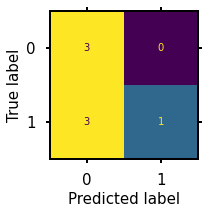

In [94]:
fig, axs = plt.subplots(1,1, figsize=(3,3))

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)
     
axs.set_ylabel('True Label', fontsize=15)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Predicted Label', fontsize=15)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=4, width=2, direction="out", pad=10)

axs.tick_params(labelsize=15)

plt.tight_layout()

disp.plot(ax=axs, colorbar=False)


plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/Conf_matrix4.png', bbox_inches='tight')